In [1]:
import matplotlib.pyplot as plt
import libertem.api as lt
import numpy as np
from libertem.analysis.getroi import get_roi
import numpy as np
from libertem.analysis import SumSigAnalysis
from libertem.analysis import ClusterAnalysis
from libertem.udf.stddev import StdDevUDF, consolidate_result
from libertem.masks import _make_circular_mask
from skimage.feature import peak_local_max
import sparse
from libertem.udf.masks import ApplyMasksUDF

In [2]:
%matplotlib nbagg

# Connection
This starts a local cluster that is accessible through ctx.

In [3]:
ctx = lt.Context()

In [4]:
params = {'path': '/home/abi/Documents/LiberTEM_data/calibrationData_circularProbe.h5', 'ds_path': '4DSTEM_experiment/data/datacubes/polyAu_4DSTEM/data'}
ds = ctx.load("HDF5", **params)

# SUM Analysis
Create an Analysis that sums all signal elements along the navigation
dimension, preserving the signal dimension.

### Parameters

  - dataset  
    the dataset to work on

### Returns

  - SumAnalysis : libertem.analysis.base.Analysis  
    When run by the Context, this Analysis generates a
    `libertem.analysis.sum.SumResultSet`.


In [ ]:
sum_analysis = ctx.create_sum_analysis(dataset=ds)
roi_params = {}
roi = get_roi(roi_params, ds.shape.nav)
udf = sum_analysis.get_udf()
sum_result = ctx.run_udf(ds, udf, roi, progress=True)

In [ ]:
plt.figure()
plt.imshow(sum_result['intensity'].raw_data)

# SumSig Analysis

In [ ]:
sumsig_analysis = SumSigAnalysis(dataset=ds, parameters={})
sumsig_result = ctx.run(sumsig_analysis, progress=True)

In [ ]:
plt.figure()
plt.imshow(sumsig_result.intensity.visualized)

# Cluster Analysis

In [6]:
parameters={'roi': {'shape': 'rect', 'x': 42, 'y': 50, 'width': 10.5, 'height': 10.5}, 'cx': 125, 'cy': 125, 'ri': 62.5, 'ro': 125, 'n_clust': 20, 'n_peaks': 500, 'min_dist': 1}
cluster_analysis = ClusterAnalysis(dataset=ds, parameters=parameters)
stddev_udf = StdDevUDF()
roi = cluster_analysis.get_sd_roi()

sd_udf_results = ctx.run_udf(dataset=ds, udf=stddev_udf, roi=roi, progress=True)

sd_udf_results = consolidate_result(sd_udf_results)

center = (parameters["cy"], parameters["cx"])
rad_in = parameters["ri"]
rad_out = parameters["ro"]
n_peaks = parameters["n_peaks"]
min_dist = parameters["min_dist"]
sstd = sd_udf_results['std']
sshape = sstd.shape
if not (center is None or rad_in is None or rad_out is None):
    mask_out = 1*_make_circular_mask(center[1], center[0], sshape[1], sshape[0], rad_out)
    mask_in = 1*_make_circular_mask(center[1], center[0], sshape[1], sshape[0], rad_in)
    mask = mask_out - mask_in
    masked_sstd = sstd*mask
else:
    masked_sstd = sstd

coordinates = peak_local_max(masked_sstd, num_peaks=n_peaks, min_distance=min_dist)

y = coordinates[..., 0]
x = coordinates[..., 1]
z = range(len(y))

mask = sparse.COO(
    shape=(len(y), ) + tuple(ds.shape.sig),
    coords=(z, y, x), data=1
)

udf = ApplyMasksUDF(
    mask_factories=lambda: mask, mask_count=len(y), mask_dtype=np.uint8,
    use_sparse=True
)

udf_results = ctx.run_udf(dataset=ds, udf=udf, progress=True)
cluster_result = cluster_analysis.get_udf_results(udf_results=udf_results, roi=roi)

 50%|█████     | 1/2 [00:03<00:03,  3.13s/it]/home/abi/libertem-venv/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/home/abi/libertem-venv/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.imputils', please update to use 'numba.core.imputils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/home/abi/libertem-venv/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'impl_ret_borrowed' requested from: 'numba.

<IPython.core.display.Javascript object>


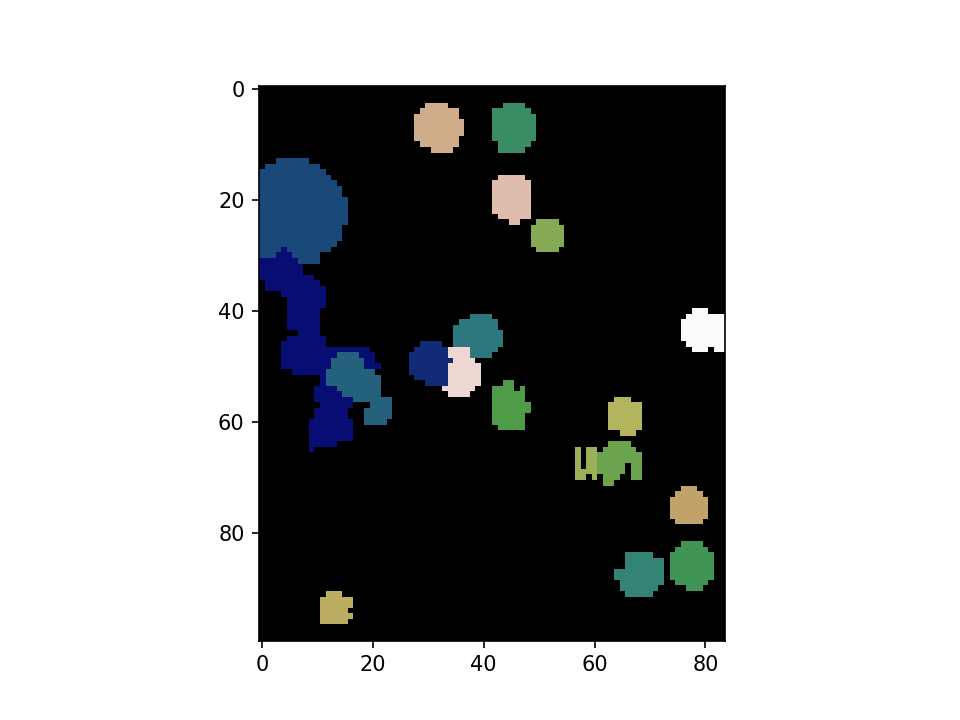

In [7]:
plt.figure()
plt.imshow(cluster_result['intensity'].visualized)